In [469]:
import pandas as pd
import re
import seaborn as sns
from bs4 import BeautifulSoup as bs
import re

In [470]:
pwd

'/Users/dheepan.ramanan/Documents/PoliticalScienceExploration/DataSets'

In [471]:
ls

842-03200558em-Senior-woman-holding-baby-goat-out-in-field.jpg
DWLegislation.xlsx
DWrollCalls.xlsx
Weekly_DW-NOMINATE_28.dta
Weekly_DW-NOMINATE_RCS_28.dta
candidate_cfscores_st_fed_1979_2012.csv
legislator.txt
party3.dat
rollcall.txt


In [472]:
Legis = pd.read_stata("../DataSets/Weekly_DW-NOMINATE_28.dta")

In [473]:
Legis.columns

Index(['cong', 'idno', 'state', 'cd', 'statenm', 'party', 'name', 'dwnom1',
       'dwnom2', 'logl', 'nchoices', 'errors', 'gmp'],
      dtype='object')

In [474]:
partyIDs = open("party3.dat").read()
partyIDsBS = bs(partyIDs,"lxml")
partylines = partyIDsBS.find("b").text.split("\n")[1:-1]
partylines = [x.lstrip() for x in partylines]
partylines[:5]

['1  Federalist',
 '9  Jefferson Republican',
 '10  Anti-Federalist',
 '11  Jefferson Democrat',
 '13  Democrat-Republican']

In [475]:
partyDict = [re.split(r"(\s)",x,1) for x in partylines]
partyDict = dict([list([int(x[0]),x[2].lstrip()]) for x in partyDict])
Legis["PartyName"] = Legis.party.apply(lambda x: partyDict[x])

In [476]:
Legis.cong.unique()[-1]
#most recent Congress number

114

In [477]:
cong114Mask = Legis.cong == 114

In [478]:
MostRecentCongress = Legis[cong114Mask == True]

In [479]:
MostRecentCongress.head(5)
demsorrepubs = MostRecentCongress.party <= 200

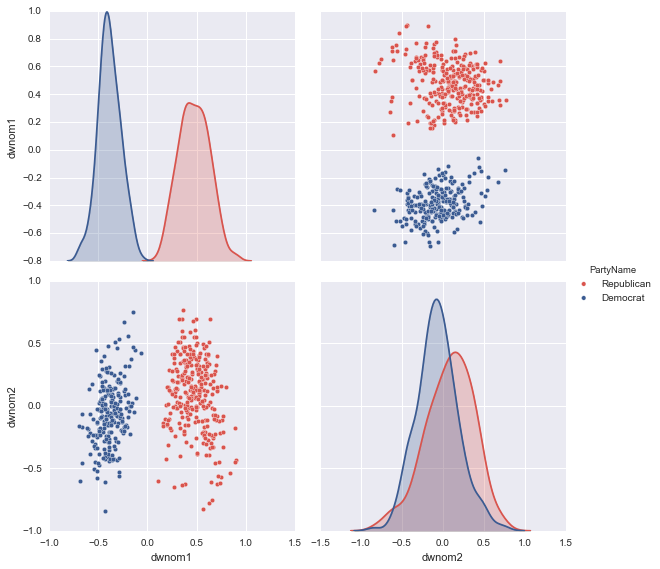

In [480]:
politicalColors = (sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"])
%matplotlib inline
graph = sns.pairplot(MostRecentCongress[demsorrepubs == True], vars=['dwnom1',
       'dwnom2'],hue="PartyName", size=4, diag_kind ="kde",diag_kws=dict(shade=True),palette=politicalColors) 

In [481]:
dems = MostRecentCongress.party == 100
gop = MostRecentCongress.party == 200
means = MostRecentCongress[demsorrepubs == True].groupby("PartyName").mean()['dwnom1'].values.tolist()

In [482]:
print("The Mean DW Nominate First Dimension for Democrats is {0:.2f} \nThe same metric gives Republicans a score of {1:.2f}"
      .format(means[0],means[1]))
print("This indicates that Republicans are more extreme in their ideology as compared to Democrats")

The Mean DW Nominate First Dimension for Democrats is -0.39 
The same metric gives Republicans a score of 0.48
This indicates that Republicans are more extreme in their ideology as compared to Democrats


In [483]:
print("The Skew for Democrats in this session of congress is {0:0.2f} and the Kurtosis is {1:0.2f}"
      .format(MostRecentCongress[dems == True].dwnom1.skew(),MostRecentCongress[dems == True].dwnom1.kurtosis()))

The Skew for Democrats in this session of congress is 0.05 and the Kurtosis is 0.02


In [484]:
print("The Skew for Republicans in this session of congress is {0:0.2f} and the Kurtosis is {1:0.2f}"
      .format(MostRecentCongress[gop == True].dwnom1.skew(),MostRecentCongress[gop == True].dwnom1.kurtosis()))

The Skew for Republicans in this session of congress is 0.12 and the Kurtosis is -0.43


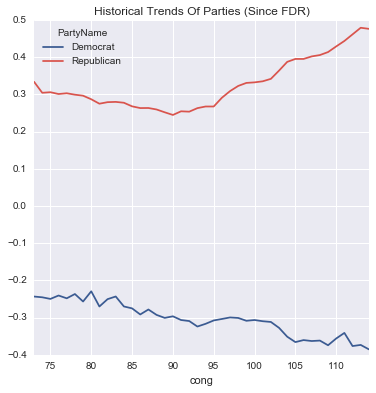

In [485]:
congressMask = Legis.cong >= 73
pc2 = list(politicalColors).reverse()
historicalDW = pd.pivot_table(Legis[congressMask == True],index=["cong","PartyName"])['dwnom1'].unstack()[['Democrat','Republican']]
historicalDW["PartySpread"] =  historicalDW.Republican - historicalDW.Democrat
historicalDW[["Democrat","Republican"]].plot(title="Historical Trends Of Parties (Since FDR)", figsize=(6,6),color=list(reversed(politicalColors)))

* The political parties have diverged in polarity since FDR
* The sharpest turn for the GOP occurs during the 95th congress (1977)

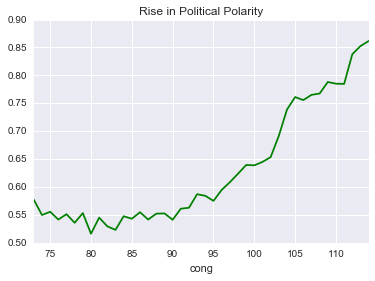

In [486]:
historicalDW["PartySpread"].plot(title="Rise in Political Polarity",style='g')

* The rise in polarisation is remarkable
* The spread between parties has risen nearly 30 points since 1977, with an acceleration occuring during my lifetime (1989)
* Let's examine the spread since the first Bush was elected

In [487]:
pre101st = historicalDW.index <= 101
post101st = historicalDW.index >= 101

In [488]:
historicalDW[post101st].mean()-historicalDW[pre101st].mean()

PartyName
Democrat      -0.074437
Republican     0.122390
PartySpread    0.196828
dtype: float32

In [489]:
partynames = [partyDict[x] for x in MostRecentCongress.party.tolist()]
MostRecentCongress["PartyNames"] = pd.Series(partynames, MostRecentCongress.index)
Congress114 = MostRecentCongress.groupby("PartyName").mean()['dwnom1']
Congress114["PartySpread"] = Congress114.Republican - Congress114.Democrat

Congress114-historicalDW[pre101st].mean()

/Users/dheepan.ramanan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


PartyName
Democrat       -0.105585
Independent          NaN
PartySpread     0.294908
Republican      0.189323
dtype: float64

* This most recent Congress has Republicans that drifted nearly .19 points to the right
* Meanwhile Democrats have moved .1 points to the left
* This shows that although the both parties have grown more polarized, Republicans exhibited twice as much movement

## Combining DW Nominate With CFScores

In [547]:
CFscores = pd.read_csv("candidate_cfscores_st_fed_1979_2012.csv")
CFscores.columns

/Users/dheepan.ramanan/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3,4,10,13,14,41,42,43,44,45,46,63,66,67,68,69,70,71,72,73,74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['cycle', 'election', 'Cand.ID', 'FEC.ID', 'NID', 'ICPSR', 'ICPSR2',
       'bonica.rid', 'bonica.cid', 'Name', 'Party', 'State', 'seat',
       'District', 'Incum.Chall', 'cfscore', 'cfscores.dyn', 'dwnom1',
       'dwnom2', 'ps.dwnom1', 'ps.dwnom2', 'num.givers', 'num.givers.total',
       'cand.gender', 'total.disbursements', 'total.pc.contribs',
       'contribs.from.candidate', 'unitemized', 'non.party.ind.exp.for',
       'non.party.ind.exp.against', 'ind.exp.for', 'ind.exp.against',
       'comm.cost.for', 'comm.cost.against', 'party.coord.exp',
       'party.ind.exp.against', 'total.receipts', 'total.indiv.contrib',
       'total.pac.contribs', 'ran.primary', 'ran.general', 'p.elec.stat',
       's.elec.stat', 'r.elec.stat', 'gen.elec.stat', 'gen.elect.pct',
       'winner', 'district.partisanship', 'mu.est80s', 'mu.est90s',
       'mu.est00s', 'district.pres.vs', 'dist.pvs1984', 'dist.pvs1988',
       'dist.pvs1992', 'dist.pvs1996', 'dist.pvs2000', 'dist.pvs2004',
      

In [557]:
CFscores["CycleYear"] = pd.to_datetime(CFscores.cycle,format="%Y")
general = CFscores["ran.general"] == 1.0
recentCycles = CFscores["CycleYear"] > "2007-01-01"
CFscores[general & recentCycles== True].shape

(34943, 79)

In [543]:
CFscores.cycle.unique()

array([1980, 1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000,
       2002, 2004, 2006, 2008, 2010, 2012, 2014])

In [562]:
candidates = CFscores[general & recentCycles== True].Name.unique().tolist()
len(candidates)

24717

* Since there are 24.7k candidates versus 35k rows we have instances of candidates showing up multiple times
* I plan to apply a clustering algorithim to find similar candidates, so I will remove non-unique candidates by filtering to only return the most recent election

In [560]:
_tempdf = pd.DataFrame(CFscores[general & recentCycles == True])

In [567]:
for c in list(enumerate(candidates)):
    candidatemask = _tempdf["Name"] == c[1]
    ind = _tempdf[candidatemask == True].sort_values(by="cycle",ascending=False).index.tolist()
    _tempdf.drop(ind[1:],inplace=True)
    if c[0] % 1000 == 0:
        print("{0} of 24717".format(c[0]))

0 of 24717
1000 of 24717
2000 of 24717
3000 of 24717
4000 of 24717
5000 of 24717
6000 of 24717
7000 of 24717
8000 of 24717
9000 of 24717
10000 of 24717
11000 of 24717
12000 of 24717
13000 of 24717
14000 of 24717
15000 of 24717
16000 of 24717
17000 of 24717
18000 of 24717
19000 of 24717
20000 of 24717
21000 of 24717
22000 of 24717
23000 of 24717
24000 of 24717


In [621]:
uniqueCandidates = _tempdf.set_index("Name").dropna(subset=["Party"])
uniqueCandidates["PartyName"] = uniqueCandidates.Party.apply(lambda x: partyDict[int(x)])

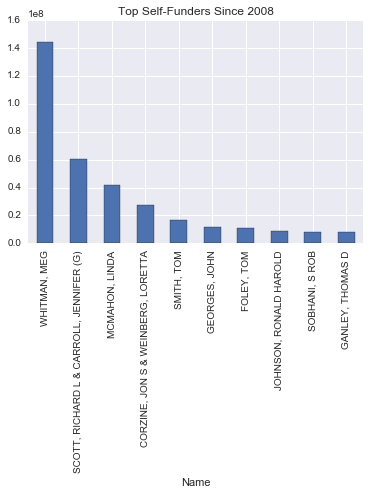

In [622]:
selfFunders = uniqueCandidates.sort_values(by='contribs.from.candidate',ascending=False).head(10)
selfFunders['contribs.from.candidate'].plot(kind="bar",title="Top Self-Funders Since 2008")

In [623]:
selfFunders[["PartyName","seat","winner","contribs.from.candidate"]]

,PartyName,seat,winner,contribs.from.candidate
Name,,,,
"WHITMAN, MEG",Republican,state:governor,L,144206328.0
"SCOTT, RICHARD L & CARROLL, JENNIFER (G)",Republican,state:governor,W,60325601.0
"MCMAHON, LINDA",Republican,federal:senate,L,41610883.0
"CORZINE, JON S & WEINBERG, LORETTA",Democrat,state:governor,L,27550650.0
"SMITH, TOM",Republican,federal:senate,L,16475000.0
"GEORGES, JOHN",Independent,state:governor,L,12024443.0
"FOLEY, TOM",Republican,state:governor,L,10865843.0
"JOHNSON, RONALD HAROLD",Republican,federal:senate,W,8938465.0
"SOBHANI, S ROB",Independent,federal:senate,L,7924205.0


* Looking at the top 10 self funders, 7 of the 10 are Republicans
* Only two of these candidates won an election

In [604]:
uniqueCandidates['seat'].value_counts()

state:lower             14004
state:upper              4569
state:committee          1796
federal:house            1639
state:office              905
state:judicial            533
nyc:city                  310
state:judicial:lower      298
state:governor            276
federal:senate            229
state:office:da            71
state:office:sheriff       71
federal:president          16
Name: seat, dtype: int64

* Let's filter by state or federal race

In [624]:
offices = uniqueCandidates['seat'].unique()
feds = list(filter(lambda x: x.split(":")[0] == "federal",offices))
state = list(filter(lambda x: x.split(":")[0] == "state",offices))
feds

['federal:senate', 'federal:president', 'federal:house']

In [625]:
fedMask  = uniqueCandidates["seat"].isin(feds) == True
stateMask = uniqueCandidates["seat"].isin(state) == True

In [634]:
uniqueCandidates[fedMask == True].groupby(["PartyName","CycleYear"]).mean()['dwnom1']

PartyName     CycleYear 
Democrat      2008-01-01   -0.350800
              2010-01-01   -0.289319
              2012-01-01   -0.410259
Independent   2008-01-01         NaN
              2010-01-01         NaN
              2012-01-01         NaN
Republican    2008-01-01    0.415183
              2010-01-01    0.484514
              2012-01-01    0.486153
Name: dwnom1, dtype: float64

In [632]:
uniqueCandidates[stateMask == True].groupby(["PartyName","CycleYear"]).mean()['dwnom1']

PartyName     CycleYear 
Democrat      2008-01-01   -0.346400
              2010-01-01   -0.397875
              2012-01-01   -0.322667
Independent   2008-01-01         NaN
              2010-01-01    0.414000
              2012-01-01         NaN
Republican    2008-01-01    0.516154
              2010-01-01    0.355909
              2012-01-01    0.397000
Name: dwnom1, dtype: float64

* Looking at these numbers it is interesting to note that state Republicans were 
the most conservative in 2008, and federal conservatives in 2010 and 2012
* Extending our analysis to previous years and adding the pruned candidates could lead to interesting 
time series analysis
* Can we forecast liberalism v conservatism in federal elections by looking at state scores?

In [699]:
fedGend = uniqueCandidates[fedMask == True]
stateGend = uniqueCandidates[stateMask == True]
fedcrosstab = pd.crosstab(fedGend['PartyName'],fedGend['cand.gender']).apply(lambda r: r/r.sum(), axis=1)
fedcrosstab

cand.gender,F,M,U
PartyName,,,
Democrat,0.232987,0.709343,0.057670
Independent,0.129252,0.829932,0.040816
Republican,0.110345,0.827586,0.062069


In [700]:
statecrosstab = pd.crosstab(stateGend['PartyName'],stateGend['cand.gender']).apply(lambda r: r/r.sum(), axis=1)
statecrosstab

cand.gender,F,M,U
PartyName,,,
Democrat,0.287335,0.618136,0.094529
Independent,0.175165,0.465551,0.359284
Republican,0.171506,0.737661,0.090834


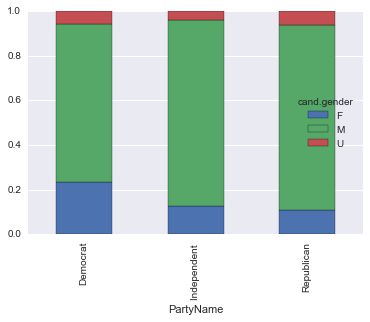

In [701]:
fedcrosstab.plot.bar(stacked=True)

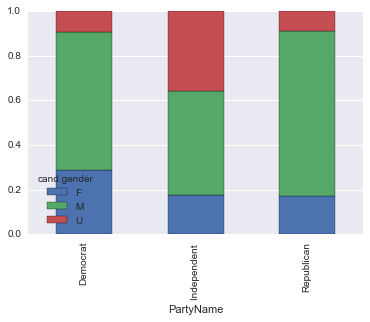

In [702]:
statecrosstab.plot.bar(stacked=True)